# Check list of deductions

- No exploratory data analysis (-3).
    - To avoid the deduction, you should do at least four or more items of the following list:
        - Search domain knowledge
        - Check if the data is intuitive
        - Understand how the data was generated
        - Explore individual features
        - Explore pairs and groups
        - Clean up features
        

- Only one predictor is used (-3)
- No feature engineering (-3)
- no model interpretation (-3)



# Overview
## Loadin data and utilities etc
## Basic EDA
- Pairs plot and correlation matrix
- Exploring NaN-values and groups
## Data cleaning
- Fixing building with wrong coords.
- Imputing some features?
## Feature engineering
- bathrooms_total, windows, ballog etc.
- metro, park and square distance
## Modeling
- PyTorch
- Random Forest, sklearn etc.
- LightGBM
- XGBoost
- CatBoost
- Combinations, stacking?

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

np.random.seed(123)
sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

# Utilities 

In [5]:
def rmsle(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5
        

# Load Data

In [34]:
apartments = pd.read_csv('resources/data/apartments_train.csv')
buildings = pd.read_csv('resources/data/buildings_train.csv')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

apartments_test = pd.read_csv('resources/data/apartments_test.csv')
buildings_test = pd.read_csv('resources/data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)

all_data = pd.concat([data, data_test])

# Exploratory Data Analysis
We begin by dividing the feature into categorical and numerical features.

In [18]:
NUMERIC_FEAT = ['area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 
                'balconies', 'loggias', 'phones', 'longitude', 'latitude', 'constructed', 'stories']

CATEORICAL_FEAT = ['seller', 'layout', 'windows_court', 'windows_street', 'condition', 'new', 'district', 'material', 
            'elevator_without', 'elevator_service', 'elevator_passenger', 'parking', 'garbage_chute', 'heating']

NO_USE = ['street', 'address']

## Pairs Plot
First we make some pairs-plots between the numerical features and the response:

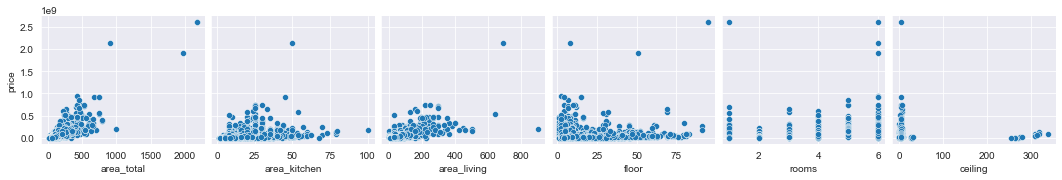

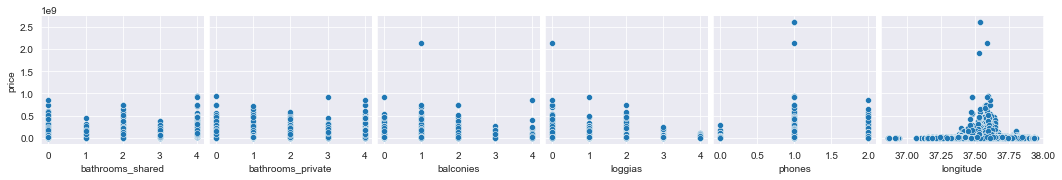

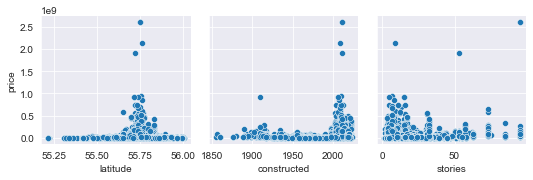

In [9]:
for i in range(0, len(NUMERIC_FEAT), 6):
    sns.pairplot(data=data[NUMERIC_FEAT + ['price']],
                x_vars=NUMERIC_FEAT[i:i+6],
                y_vars=['price'])

We also do a pairs plot with the log of the response:

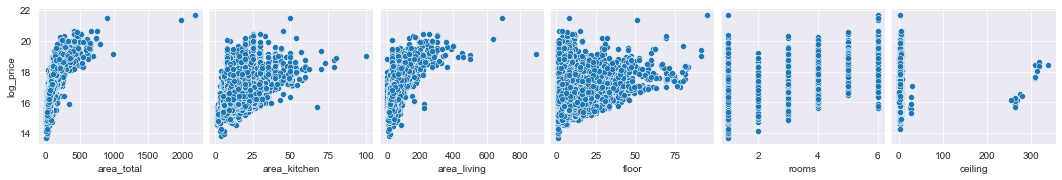

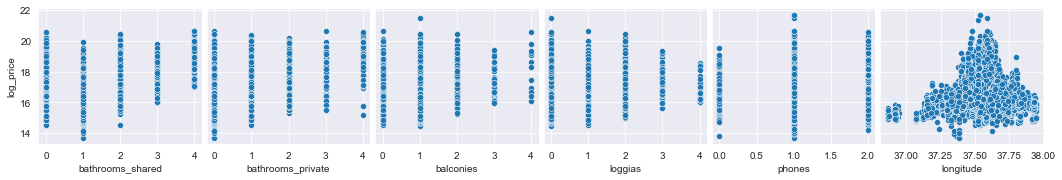

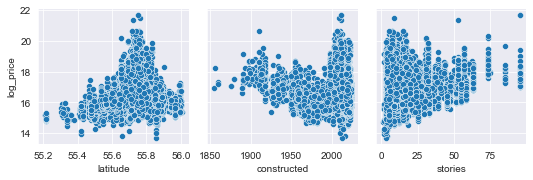

In [11]:
data['log_price'] = np.log(data.price)
for i in range(0, len(NUMERIC_FEAT), 6):
    sns.pairplot(data=data[NUMERIC_FEAT + ['log_price']],
                x_vars=NUMERIC_FEAT[i:i+6],
                y_vars=['log_price'])

From the plots, we see that there is a strong linear relationship between the price and the area-related features, especially `area_total`. `floor`, `rooms` and `stories` also seem to have a linear relationship, at least with the log of the response. It is clear that `longitude` and `latitude` have a nonlinear relationship with the response. Some of these features, e.g. `phones` should maybe be treated as categorical.

## Correlation Matrix
Next, we construct a correlation matrix with both price and numerical features.

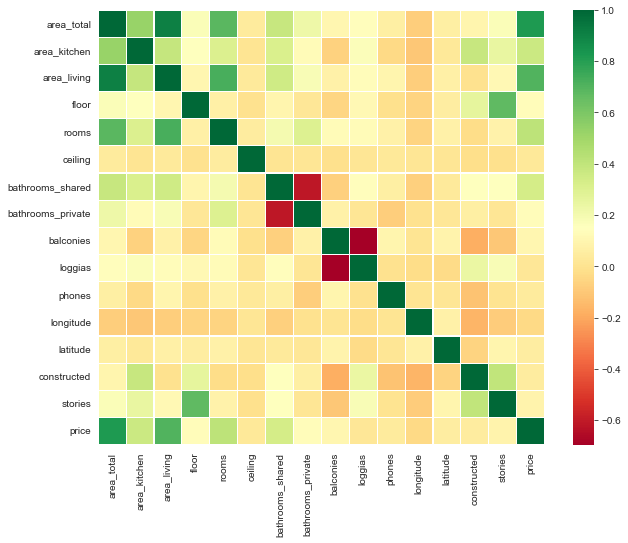

In [13]:
sns.heatmap(data[NUMERIC_FEAT + ['price']].corr(),annot=False,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

The correlation matrix confirms the observed relationships in the pairs-plot.

## Categorical Features
Next, we have a look at the categorical features. We include a category for the missing values for each feature.

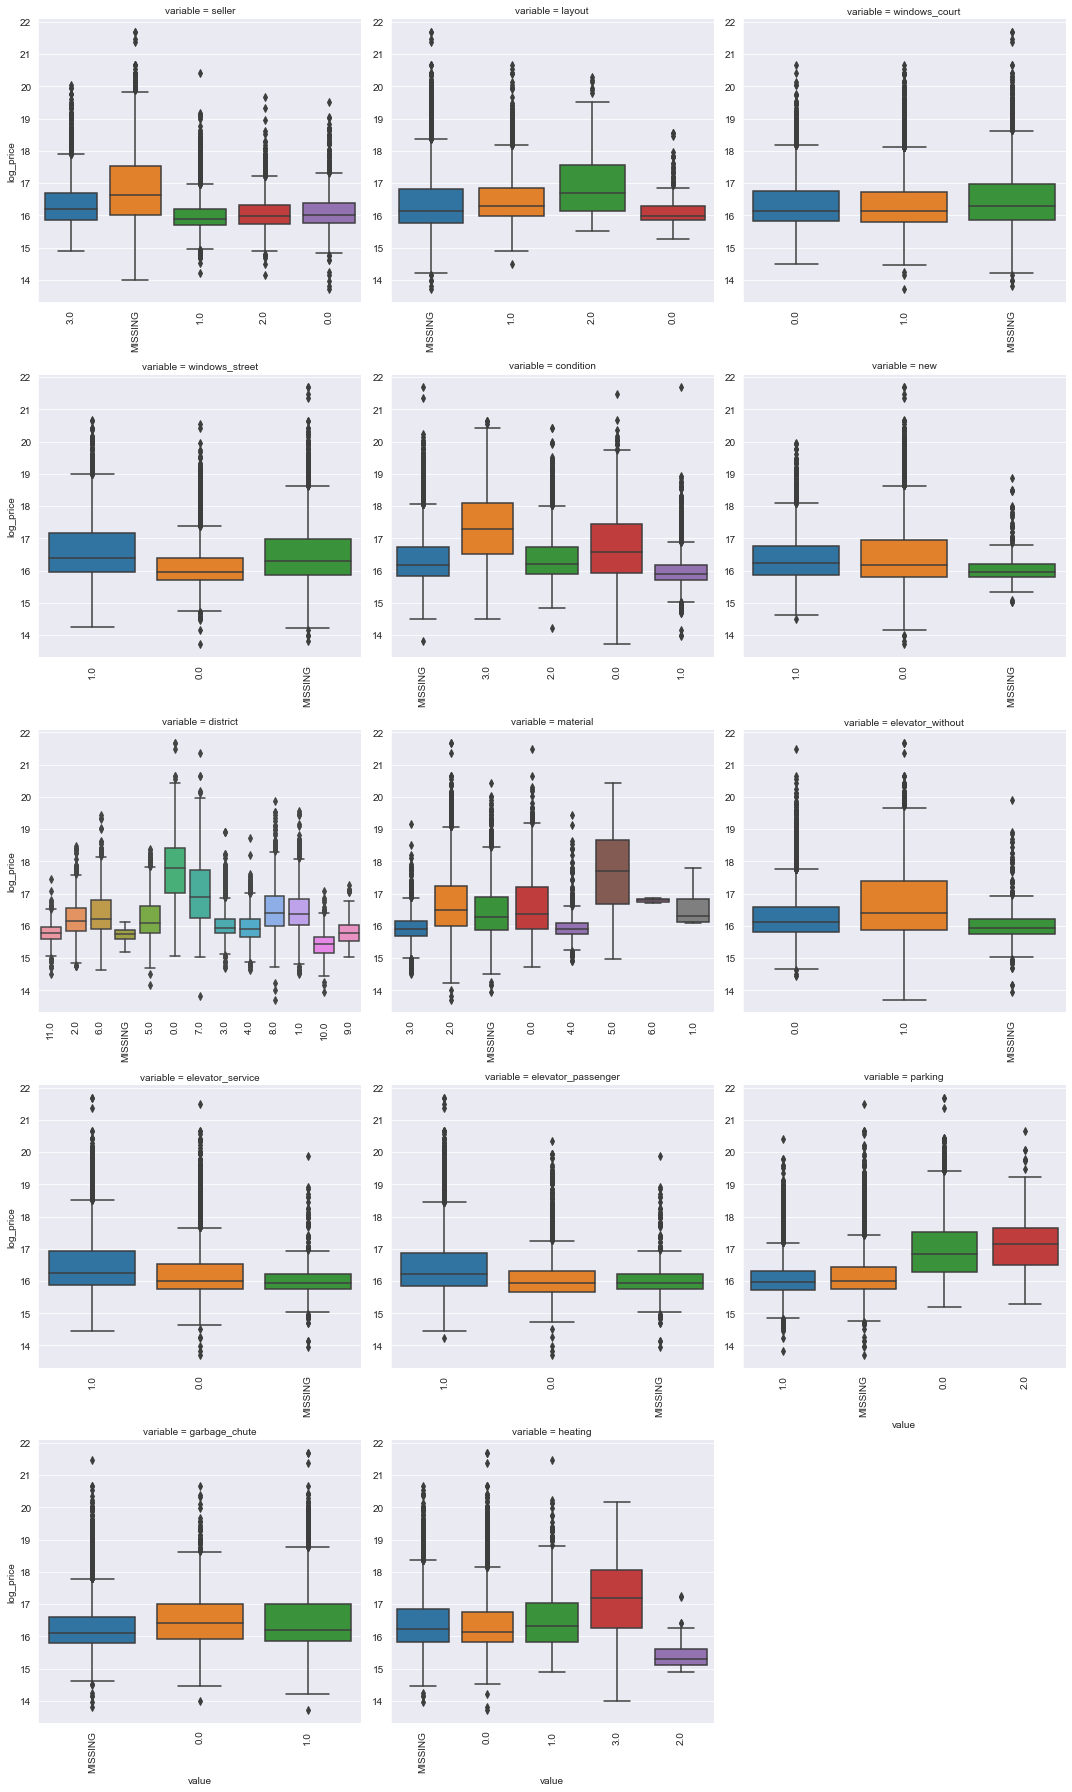

In [22]:
data_cat = data[CATEORICAL_FEAT + ['log_price']].copy() # Use log of price.

for c in CATEORICAL_FEAT:
    data_cat[c] = data_cat[c].astype('category')
    if data_cat[c].isnull().any():
        data_cat[c] = data_cat[c].cat.add_categories(['MISSING'])
        data_cat[c] = data_cat[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(data_cat, id_vars=['log_price'], value_vars= CATEORICAL_FEAT)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "log_price")

From the plot, `district` seems to be important. `material`, `heating` and `parking`also seem to have some important price differences among categories.
## Exploring Missing Values

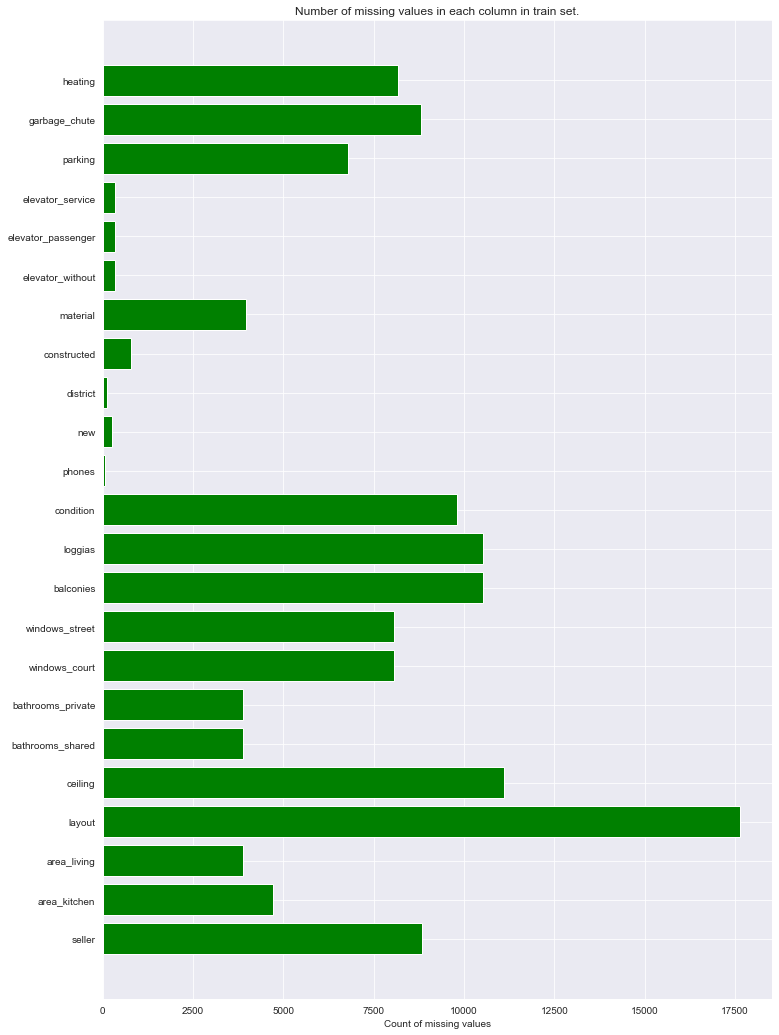

In [25]:
# Plotting missing values in the train set
missing_df = data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='g')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column in train set.")
plt.show()

Text(0.5, 1.0, 'Number of missing values in each column in test set.')

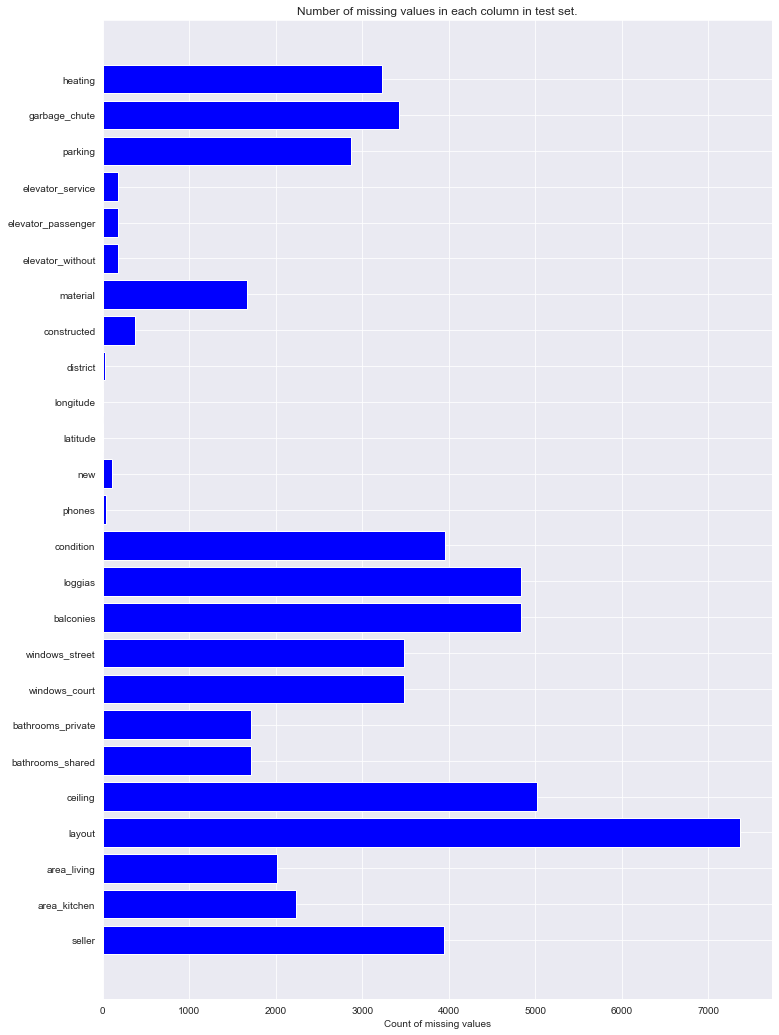

In [30]:
# Plotting missing values in the test set.add
missing_df = data_test.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column in test set.")

We observe that some data seems to be missing in gropus. Foe example, the features related to `windows` seem to either be missing or not (at the same time). This can easily be checked:

In [36]:
# Check if windows_court and windows_street are always simultaneously NAN or not.
all_data.loc[ ~all_data.windows_court.isna(), 'windows_street'].isna().any()

False

The same can be checked for `balconies` and `loggias`, features related to `elevator` and features related to `bathrooms`. This tells us something about how the data was generated, and could come in hand for our feature engineering.